# RoBERTa-based Manipulation Detection (Binary Classification) ith PEFT/LORA added
This notebook uses `roberta-base` to classify dialogue as manipulative or not using the MentalManip dataset.

In [39]:
!pip install -q transformers
!pip install -q datasets
!pip install -q evaluate
## transformers upgrade
!pip install -q --upgrade transformers

## Datasets need upgrading to work
!pip install -q --upgrade datasets

## LoRA addon
!pip install -q peft accelerate

## Seaborn for plotting the label distribution
!pip install -q seaborn

## Early stopping
from transformers import EarlyStoppingCallback


In [40]:
import numpy as np
import pandas as pd
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report

## PLotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [41]:

from transformers import Trainer
import torch
from torch.nn import CrossEntropyLoss

class WeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


In [42]:
# Load the MentalManip dataset (binary classification)
# Load dataset
dataset = load_dataset("audreyeleven/MentalManip", name="mentalmanip_maj")

print(dataset)


Some datasets params were ignored: ['license']. Make sure to use only valid params for the dataset builder and to have a up-to-date version of the `datasets` library.


DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability'],
        num_rows: 4000
    })
})


In [43]:

# Filter dataset for binary inference on "Persuasion or Seduction"
target_label = "Persuasion"



def label_for_binary(example):
    if example["technique"] == None:
      return 0

    if example["technique"]:
      if target_label in example["technique"]:
         return 1
      else:
        return 0



# Apply to all splits
dataset = dataset.map(lambda x: {"labels": label_for_binary(x)})
label_list = [0, 1]
id2label = {0: "non-target", 1: target_label}
label2id = {"non-target": 0, target_label: 1}

print("Binary labels applied for:", target_label)
print(dataset)
print(dataset['train']['labels'])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Binary labels applied for: Persuasion
DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels'],
        num_rows: 4000
    })
})
Column([0, 0, 1, 0, 1])


/tmp/ipython-input-44-2194669225.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='labels', data=df, order=df['labels'].value_counts().index,  palette="viridis")


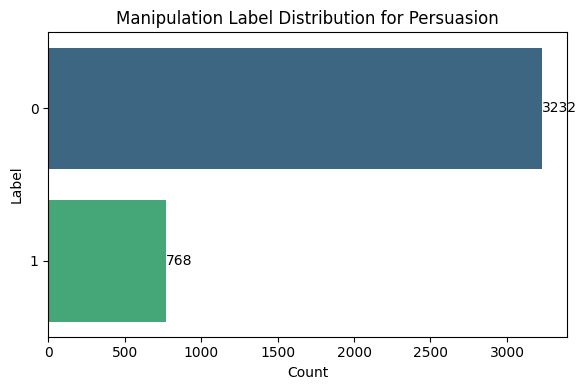

In [44]:
df = dataset["train"].to_pandas()


## PLot the label distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(y='labels', data=df, order=df['labels'].value_counts().index,  palette="viridis")
# Loop through each container of bars and add labels
for container in ax.containers:
    ax.bar_label(container)



plt.title(f"Manipulation Label Distribution for {target_label}")
plt.xlabel("Count")
plt.ylabel("Label")
plt.tight_layout()
plt.show()

In [45]:
model_ckpt = "roberta-base"

In [46]:
# Ensure the column is class-labeled
dataset = dataset.class_encode_column("labels")

print(dataset)


Stringifying the column:   0%|          | 0/4000 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels'],
        num_rows: 4000
    })
})


In [47]:
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize_fn(example):
    return tokenizer(example["dialogue"], truncation=True, padding="max_length", max_length=128)

tokenized = dataset.map(tokenize_fn, batched=True)
print(tokenized)

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 4000
    })
})


In [48]:
## Setup the PEFT addon

from peft import get_peft_model, LoraConfig, TaskType

# Define your LoRA configuration
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,           # Sequence classification
    inference_mode=False,                 # True = inference only
    r=8,                                  # Low-rank dimension
    lora_alpha=16,                        # Scaling factor
    lora_dropout=0.1,                     # Dropout in LoRA layers
    bias="none",
    target_modules=["query", "value"]     # Apply only to LoRA layers
)

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


In [49]:

base_model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=2)

# Wrap with LoRA
model = get_peft_model(base_model, peft_config)

# Pring trainable layers
for name, module in model.named_modules():
    if "attention" in name and any(k in name for k in ["query", "key", "value"]):
        print(name)


# Optional: Show how many parameters are trainable
model.print_trainable_parameters()





Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


base_model.model.roberta.encoder.layer.0.attention.self.query
base_model.model.roberta.encoder.layer.0.attention.self.query.base_layer
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_dropout
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_dropout.default
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_A.default
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_B.default
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_embedding_A
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_embedding_B
base_model.model.roberta.encoder.layer.0.attention.self.query.lora_magnitude_vector
base_model.model.roberta.encoder.layer.0.attention.self.key
base_model.model.roberta.encoder.layer.0.attention.self.value
base_model.model.roberta.encoder.layer.0.attention.

In [50]:

from collections import Counter
import torch

label_counts = Counter(dataset['train']['labels'])
total = sum(label_counts.values())
weights = [total / label_counts[i] for i in range(len(label_counts))]
class_weights = torch.tensor(weights).to(model.device)
print("Class weights:", class_weights)


Class weights: tensor([1.2376, 5.2083])


In [51]:
# Split the dataset into training and testing sets
train_test_split = tokenized["train"].train_test_split(test_size=0.2) # Adjust the test_size as needed

# Update the tokenized dataset with the new splits
tokenized["train"] = train_test_split["train"]
tokenized["test"] = train_test_split["test"]

# Make the data work with the nomenclature
#tokenized = tokenized.rename_column("manipulative", "labels")

print(tokenized)

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 3200
    })
    test: Dataset({
        features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 800
    })
})


In [52]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_ckpt,
    num_labels=2  # Binary classification
)


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
## Stop epochs if overfitting
early_stopping = EarlyStoppingCallback(
    early_stopping_patience=2,  # Stop after 2 epochs without improvement
    early_stopping_threshold=0.0
)


In [54]:
## Training args

training_args = TrainingArguments(
    metric_for_best_model='f1',  ## F1 metrics
    greater_is_better=True,
    output_dir="./bert-binary-manip",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=8,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    run_name="bert-binary-manip",
    report_to="none",
    learning_rate=2e-5,
)

In [55]:
## Evaluation metrics

import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')
precision = evaluate.load('precision')
recall = evaluate.load('recall')
f1 = evaluate.load('f1')

def compute_metrics(p):
    predictions, labels = p
    predictions_argmax = np.argmax(predictions, axis=1)

    return {
        "accuracy": accuracy.compute(predictions=predictions_argmax, references=labels)["accuracy"],
        "precision": precision.compute(predictions=predictions_argmax, references=labels, average='weighted')["precision"],
        "recall": recall.compute(predictions=predictions_argmax, references=labels, average='weighted')["recall"],
        "f1": f1.compute(predictions=predictions_argmax, references=labels, average='weighted')["f1"],
    }

In [56]:
from transformers import Trainer
from torch.nn import CrossEntropyLoss
import torch

# Custom Trainer with class-weighted loss
class CustomWeightedLossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Move class_weights to the same device as the model
        loss_fct = CrossEntropyLoss(weight=self.class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss


trainer = CustomWeightedLossTrainer(
    class_weights=class_weights,
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[early_stopping], # Pass callbacks here, early overfit stop
)
trainer.train()

/tmp/ipython-input-56-1091749800.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomWeightedLossTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.663600,0.668232,0.805000,0.765772,0.805000,0.773357
2,0.590400,0.610558,0.591250,0.810237,0.591250,0.633716
3,0.498100,0.629149,0.678750,0.793767,0.678750,0.711860


TrainOutput(global_step=600, training_loss=0.6101945479710896, metrics={'train_runtime': 270.0968, 'train_samples_per_second': 94.781, 'train_steps_per_second': 5.924, 'total_flos': 631466532864000.0, 'train_loss': 0.6101945479710896, 'epoch': 3.0})

In [57]:

##  Easy eval results...
##  Get the log history from the trainer state
log_history = trainer.state.log_history

# Initialize placeholders
last_train_loss = None
last_eval_loss = None

# Iterate through log history to find the last recorded train and eval loss
for log in reversed(log_history):
    if last_eval_loss is None and "eval_loss" in log:
        last_eval_loss = log["eval_loss"]
    if last_train_loss is None and "loss" in log:
        last_train_loss = log["loss"]
    if last_train_loss is not None and last_eval_loss is not None:
        break

# Calculate overfitting ratio
if last_train_loss is not None and last_eval_loss is not None:
    ratio = last_train_loss / last_eval_loss
    print(f"Training Loss: {last_train_loss:.5f}")
    print(f"Validation Loss: {last_eval_loss:.5f}")
    print(f"Overfitting Ratio: {ratio:.5f}")
    if ratio < 0.6:
        print("Overfitting detected!")
    else:
        print("No significant overfitting.")
else:
    print("Could not find both training and evaluation loss in log history.")


Training Loss: 0.49810
Validation Loss: 0.62915
Overfitting Ratio: 0.79170
No significant overfitting.


In [58]:
# Predict on test set
preds = trainer.predict(tokenized["test"])
y_pred = preds.predictions.argmax(-1)
y_true = preds.label_ids

# Detailed classification report
print(classification_report(y_true, y_pred, target_names=["non-manipulative", "manipulative"]))


                  precision    recall  f1-score   support

non-manipulative       0.84      0.94      0.89       649
    manipulative       0.46      0.21      0.28       151

        accuracy                           0.81       800
       macro avg       0.65      0.57      0.59       800
    weighted avg       0.77      0.81      0.77       800



In [59]:
print(train_test_split["train"])
from collections import Counter
print("Label distribution in training set:", Counter(train_test_split["train"]['manipulative']))
print("Label distribution in validation set:", Counter(train_test_split["test"]['manipulative']))


Dataset({
    features: ['id', 'dialogue', 'manipulative', 'technique', 'vulnerability', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 3200
})
Label distribution in training set: Counter({1: 2250, 0: 950})
Label distribution in validation set: Counter({1: 568, 0: 232})


In [60]:

preds = trainer.predict(train_test_split["test"])
import numpy as np
predicted_labels = np.argmax(preds.predictions, axis=1)
print("Predicted label distribution:", dict(Counter(predicted_labels)))


Predicted label distribution: {np.int64(0): 733, np.int64(1): 67}


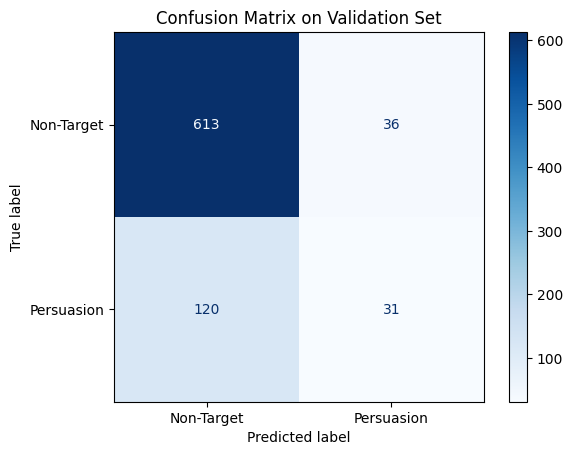

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Get predictions from validation set
predictions = trainer.predict(tokenized["test"])
y_true = predictions.label_ids
y_pred = np.argmax(predictions.predictions, axis=1)

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Target", "Persuasion"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Validation Set")
plt.show()